# Mapping and Prediction of Incised Features.

In [2]:
%%capture

# NOTE: CAN CONSIDER PULLING STEP 3 (9x9m) DOWN INTO FINEST SCALE STEP BECAUSE PROFILE CURVATURE IS STILL RELEVANT
# AT THIS SCALE. CURRENTLY PROFILE CURVATURE IS ONLY USED AT STEP 1 AND 2.

import numpy as np
import xarray as xr
import scipy
import gdal
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline

# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 
from landlab.plot.imshow import imshow_node_grid 
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, SinkFiller
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
#, x1 = None, x2 = None, y1 = None, y2 = None
# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

## Set algorithm inputs.

In [3]:
level_of_generalisation = 6 # This value is equal to 1 - L where L is the coarses level of interest.

location = (r'D:/PhD/junk')
os.chdir(location)
#ACT2015_8ppm_6866092_55_0002_0002_1m
ds = gdal.Open('wean_1m.tif')
initial_resolution = 1
x = np.array(ds.GetRasterBand(1).ReadAsArray())

input_DEM = x[3000:4000, 4000:5000]
              
# Kernel can also be implemented as two one dimesnional arrays first in the x direction and then in the y direction.
# Need to to a speed test of 2 x 1D vs 1 x 2D.

kernel = np.loadtxt('kernel.txt')
kernel_1d = np.reshape(kernel,(1,121)) # Making the kernel 1d to work inside the ndimage generic_filter function.


(1000, 1000)

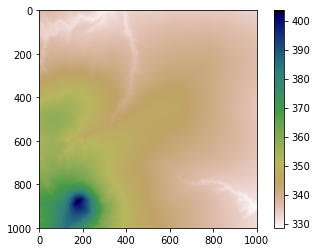

In [4]:
plt.imshow(input_DEM, cmap="gist_earth_r")
plt.colorbar()
input_DEM.shape

## Define required functiions.

In [5]:
def x_y_size_test(input_array, resolution_ratio, resample_levels, number_of_options):
    
    """This function checks the size of the array and ensures that it can be resampled up and down 
    by a factor of three and always result in an array of the original size."""
    
    # Check number of rows and columns. 
    rows = np.size(input_array, 0)
    columns = np.size(input_array, 1)
    
    array_sizes = []
    for i in range(1,number_of_options):
        min_dim_size = resolution_ratio ** resample_levels
        ideal_array = i * min_dim_size
        array_sizes.append(ideal_array)

    ideal_row = next(x[1] for x in enumerate(array_sizes) if x[1] > rows)
    ideal_col = next(x[1] for x in enumerate(array_sizes) if x[1] > columns)
    
    add_rows = ideal_row - rows
    add_columns = ideal_col - columns
    
    empty_array = np.zeros((rows + add_rows, columns + add_columns)) # Create an empty array to the pad if required.
    
    offset_rows = int(-1 * add_rows)
    offset_columns = int(-1 * add_columns)
    
    empty_array[:offset_rows, :offset_columns] = input_array
    
    return empty_array


# Setup some resampling functions.

def resample_resolution_lower(data, ratio):
    
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    
    zoom_factor = Fraction(1,3 ** ratio)
    
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    
    return resample

# First setup functions for changing resolution of data

def resample_resolution_higher(data, ratio):
    
    """Takes some gridded data and a desired resampling ratio. For example, a resolution ratio 
       of 3 means that for data of a base resolution == 25m, one step up in resolution would be 75m
       and one step up from that would be 225m etc""" 
    
    zoom_factor = 3 ** ratio
    
    # Order one is bilinear interpolation.
    resample = scipy.ndimage.zoom(data, zoom_factor, order = 1)
    
    return resample

# Setup functions to calculate slope for input DEM

def rectangleWindow(m, n):
    
    """Takes a value for number of rows (m) and number of columns (n) such that
       m and n are both positive real numbers and creates a rectangle of 
       boolian 'True' values."""
    
    rectangle = np.ones((m, n), dtype=bool) 

    return rectangle

def number_of_values(Window):
            
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == rectangle type 'number_of_values(rectangleWindow(m,n)) 
        where m and n are any positive real number as per the rectangleWindow function."""
        
    denominator = sum(sum(Window > 0))
    
    return denominator

#Note: using median like this only gives the correct value for circles with odd radius values.

def slopeWindow(DEM, x_cellsize, y_cellsize):
    
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
        
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
       
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    
    slope_percent = rise_run * 100
    
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_percent

# The 'extra_arguments' variable requires a value that represents r in the PCTL function defined above.
# The reason it need to be assigned to a seperate variable is that the generic_filter function only allows the
# input function (PCTL in this case) to take one argument (S1). Then, if the input function normally takes more
# than one argument the 'extra_arguments' variable needs to be defined as a tuple (hence (3,) instead of (3)).

def slopeWindowDegrees(DEM, x_cellsize, y_cellsize):
    
    """This function implements slope calculation using the same algorithm
       as ARCGIS (Outlined on the page 'How Slope Works').
       
       This particular example of the function is written such that it
       will only work if called within the ndimage generic_filter (as the first input).
       This is because the index arguments for a-e are given for the 1d array created
       by the generic_filter function after extracting values from the 3,3 rectangle window.
       
       NOTE: THIS FUNCTION ONLY WORKS WITH A 3x3 RECTANGLE WINDOW."""
    
    a = DEM[0]; b = DEM[1]; c = DEM[2]
    d = DEM[3]; e = DEM[4]; f = DEM[5]
    g = DEM[6]; h = DEM[7]; i = DEM[8]
        
    dzdx = ((c + (2*f) + i) - (a + (2*d) + g)) / (8 * x_cellsize)
    dzdy = ((g + (2*h) + i) - (a + (2*b) + c)) / (8 * y_cellsize)
    
    rise_run = np.sqrt(dzdx**2 + dzdy**2)
       
    slope_degrees = np.arctan(rise_run) * (180/math.pi)
    
    slope_percent = rise_run * 100
    
    #Can also ask it to return slope_degrees but askinh for both causes it to throw and error.
    return slope_degrees

def planCurvature(DEM, cellsize):
        
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
        
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    
    plan_curvature = (2 * (D*(H**2) + E*(G**2) - (F*G*H))) / (G**2 + H**2)

    return plan_curvature

def profileCurvature(DEM, cellsize):
    
    """This process is taken from Change (2014, Introduction to Geographic Information
    systems, Page 284)."""
        
    Z1 = DEM[0]; Z2 = DEM[1]; Z3 = DEM[2]
    Z4 = DEM[3]; Z0 = DEM[4]; Z5 = DEM[5]
    Z6 = DEM[6]; Z7 = DEM[7]; Z8 = DEM[8]
        
    D = (((Z4 + Z5)/2) - Z0) / cellsize**2
    E = (((Z2 + Z7)/2) - Z0) / cellsize**2
    F = (Z3 - Z1 + Z6 - Z8)/ (4 * cellsize**2)
    G = (Z5 - Z4) / (2 * cellsize)
    H = (Z2 - Z7) / (2 * cellsize)
    
    profile_curvature = (-2 * (D*(G**2) + E*(H**2) + (F*G*H))) / (G**2 + H**2)

    return profile_curvature

def circleWindow(radius):
    
    """Takes a value for radius (r where r is any positive real number) and creates 
       a circular window using that radius."""
    
    y, x = np.ogrid[-radius: radius + 1, -radius: radius + 1]
    circle = x**2 + y**2 <= radius**2
    return circle

def number_of_values(Window):
            
    """This funciton takes the shape function as an input and returns a number 
        of values present in the specified shape. 
        
        This can be different for a different window shape and to initialize
        requires the specification of the function for the given window type and 
        parameter values required for that input function.
        
        To initialize this function for shape == circle type 'number_of_values(circleWindow(r)) 
        where r is any positive real number as per the circleWindow function."""
        
    denominator = sum(sum(Window > 0))
    return denominator

#Note: using median like this only gives the correct value for circles with odd radius values.

def find_median_value(Window):
    
    """This function takes the shape function and returns the median value 
        for all valid values (values that fall in the circle) arranged into a 
        1d array. The function also takes the number_of_values function as an input.
        To execute this function type 'find_median_value(shape(r)) where r is any integer."""
    
    no_values = number_of_values(Window)
    value_range = np.arange(0, no_values + 1)
    central_value = int(np.median(value_range))
    return central_value

# Define a function to be used by the generic_filter function.

#This function calculates the percentile of a central value within its circular neighborhood.

def PCTL(x):
    
    """This function only works as an inside function to generic_filter function below. This
    is because generic_filter will take a 2d array and reshape it into a 1d array. Without this 
    step the 'central_value' variable will be outside of the array dimensions. 
    x = input DEM and r = radius of search window """
    
    centroid = x[central_value]                        
    y = np.sum(x < centroid)/num_values#Count number of values greater than centroid value
    return y

# Calculate elevation percentile with a radius of 3. Use percentile_filter from ndimage.


def Nxtp(x, t, p):
    
    """Takes a DEM derivative (x, such as slope or elevation percentile 
    and maps it onto the range [0,1] using a non-linear equation with a shape 
    parameter (t) and a threshold parameter (p)"""
    
    standardise_value = 1/(1+(x/t)**p)
    print (x)
    print (t)
    print (p)
    return standardise_value

def TWI(slope, area, cell_resolution):
    """Calculates Topographic Wetness Index (TWI) taking a slope layer in degrees,
    the catchment area of the cell calculated using a chosen flow routing algorithm and 
    the cell resolution of the slope and catchment area layers input as an integer."""
    As = np.divide(area, cell_resolution)
    slope_radians = np.deg2rad(slope)
    tanB = np.tan(slope_radians)
    W = np.log(np.divide(As, tanB))
    return W

def CTI(slope, area, cell_resolution):
    """Calculates Compound Topographic Index (TWI) taking a slope layer in degrees and
    the catchment area of the cell calculated using a chosen flow routing algorithm."""
    As = np.divide(area, cell_resolution)
    slope_radians = np.deg2rad(slope)
    C = np.multiply(As, slope_radians)
    return C
    

def gaussian_filter(image, kernel):
    
    """This function applies a gaussian smoothing filter to the data. It takes an input DEM
    and kernel file (read in as a numpy array). This is the exact same filter used by MRVBF"""
    
    convolution = np.mean(np.multiply(kernel, image))
    return convolution

def find_matching_level(L):
    find_divisor_integer = L//2
    find_remainder = L%2
    matching_generalisation_level = find_divisor_integer + find_remainder
    matching_cell_resolution = matching_generalisation_level - find_remainder
    return matching_generalisation_level, matching_cell_resolution
        
    

## Create dictionary of resampled DEMs.

In [6]:
minimum = np.amin(input_DEM)
minimum
mask_template = np.copy(input_DEM)
mask_template[mask_template != minimum] = 1
mask_template[mask_template == minimum] = np.nan
mask = x_y_size_test(mask_template, 3, 5, 100)
mask

DEM = x_y_size_test(input_DEM, 3, 5, 100)
DEM[DEM < minimum] = minimum
DEM.shape

(1215, 1215)

In [67]:
start = timeit.default_timer()
flow_acc_surf = np.copy(DEM)
rows = input_DEM.shape[0] - 1
cols = input_DEM.shape[1] - 1
flow_subset = flow_acc_surf[0:rows, 0:cols]

mg = RasterModelGrid((rows,cols), spacing=(initial_resolution, initial_resolution))
mg.add_field('topographic__elevation', flow_subset, at = 'node')
fa = FlowAccumulator(mg,
                    surface = 'topographic__elevation',
                    flow_director = 'FlowDirectorD8',
                    depression_finder = 'DepressionFinderAndRouter')
stop=timeit.default_timer()
time = stop - start
print('Time taken' + ' = ', time, 'seconds')

Time taken =  8.810157091973224 seconds


In [25]:
surf_plot(mg, title='Grid 1', colormap = cm.Greens)

NameError: name 'fmg' is not defined

In [86]:
start = timeit.default_timer()

(flow_acc, q) = fa.accumulate_flow()

stop = timeit.default_timer()
time = stop - start
print('Time taken' + ' = ', time, 'seconds')

Time taken =  0.012463802469937946 seconds


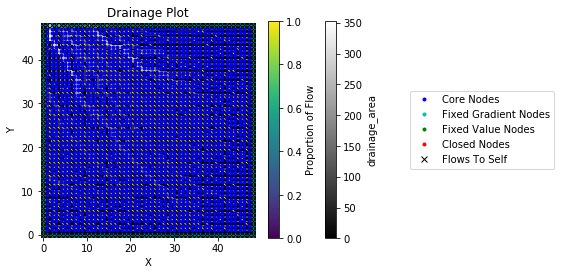

In [87]:
drainage_plot(mg, 'drainage_area')

In [10]:
ca = np.array(mg.at_node['drainage_area'])

17037.0

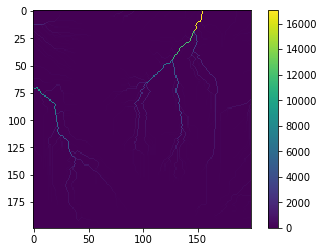

In [11]:
dr = ca.reshape(rows,cols)
plt.imshow(dr)
plt.colorbar()
np.amax(dr)

In [7]:
# Want to make sure that this is setting up a grid shape that is divisible by the largest cell
# resolution of Lm1. I can find this with the equation 3**(n - 3) where n = level_of_generalisation.

#This function is designed to work only within the below loop.

def prep_model_grid(original_dem):
    """This function is used to take a subset of the current workign DEM equal in size to the 
    maximum possible given the resolution of the current processing step. It assesses by how many 
    rows and columns the input DEM needs to be decreased by in order to be perfectly divisibale
    by the resolution of the current processing step."""
    divide_by = 3**(int(Lm1) - 1)
    nibble_by = original_dem.shape[0] % divide_by
    DEM_subset = np.copy(original_dem)
    if nibble_by == 0:
        return original_dem
    else:
        topo_surface = DEM_subset[0:-nibble_by, 0:-nibble_by]
        return topo_surface

array_DEM = {}
DEM11 = np.copy(DEM)
array_DEM.setdefault('DEM'+ '1' + '1', []).append(DEM11);
DEM21 = median_filter(DEM, size = 7, mode = 'nearest')
array_DEM.setdefault('DEM'+ '2' + '1', []).append(DEM21);
DEM22 = resample_resolution_lower(DEM21, 1);
array_DEM.setdefault('DEM'+ '2' + '2', []).append(DEM22);

for i in range(3, level_of_generalisation): 
    L = str(i) 
    Lm1 = str(i - 1)
    DEML_Lm1 = median_filter(array_DEM['DEM'+ Lm1 + Lm1][0], size = 7, mode = 'nearest')
    array_DEM.setdefault('DEM'+ L + Lm1, []).append(DEML_Lm1);
    DEML_L = resample_resolution_lower(DEML_Lm1, 1);
    array_DEM.setdefault('DEM'+ L + L, []).append(DEML_L);
    flow_acc_surf = np.copy(DEML_Lm1);
    print(DEML_Lm1.shape)
    resolution_step_L = 3**(int(L) - 2); 
    print(resolution_step_L)
    #################################################################################################
    # This is just ensuring the DEM has the correct properties to work within the model grid 
    # structure of LandLab. The 'prep_model_grid' function is defined above.
    flow_subset = prep_model_grid(input_DEM).astype('float64')
    
    #################################################################################################
    # Now determine the actual size of the subset DEM by dividing each axis by the resolution of
    # the current processing step.
    rows = int(flow_subset.shape[0] / resolution_step_L)
    cols = int(flow_subset.shape[1] / resolution_step_L)    
    # Now extract the designated subset from the current working DEM.
    input_surface = flow_acc_surf[0:rows, 0:cols]
    #The output is now fed into a RasterModelGrid to process flow accumulation.
    mg = RasterModelGrid((rows,cols), spacing=(resolution_step_L, resolution_step_L))
    mg.add_field('topographic__elevation', input_surface, at = 'node')
    fa = FlowAccumulator(mg,
                        surface = 'topographic__elevation',
                        flow_director = 'FlowDirectorD8',
                        depression_finder = 'DepressionFinderAndRouter')
    (flow_acc, q) = fa.accumulate_flow()
    da = np.array(mg.at_node['drainage_area'])
    dr = da.reshape(rows,cols)
    # Finally insert the flow accumulation subset back into the larger DEM that the subset was taken from
    # and append to dictionary.
    flow_acc_surf[0:rows, 0:cols] = dr        
    array_DEM.setdefault('CA'+ L + Lm1, []).append(flow_acc_surf);    

(405, 405)
3
(135, 135)
9
(45, 45)
27


In [8]:
%%capture
# Create a higher level mask from TWI/CTI/elevation.

start = timeit.default_timer()
array_LL = {}
array_LL.setdefault('DEM22', []).append(DEM);
range_min = 2
range_max = level_of_generalisation
pl_value = 1
weight_coef = 0
radius = 6
central_value = find_median_value(circleWindow(radius))
num_values = number_of_values(circleWindow(radius))

step_L = range_max
for i in range(range_min, range_max):
    step_L = i
    L = str(step_L)
    print(step_L)
    Lm1 = str(int(step_L) - 1)
    Lp1 = str(int(step_L) + 1)
    # Determine the cell resolution for step L.
    resolution_step_L = 3**(int(Lm1) - 1)
    # Minus 1 is here because the first step is not resampled at all and 3 to the power of 0 == 1.
    # Resample (coarsen) smoothed DEM to current step (DEM  L, L).
    DEML_L = np.copy(array_DEM['DEM'+ L + L][0])
    DEML_Lm1 = np.copy(array_DEM['DEM'+ L + Lm1][0])
    
    PCTLL_L = generic_filter(DEML_L, PCTL, footprint= circleWindow(radius), mode='constant')
    #array_LL.setdefault('PCTL'+ L + L, []).append(PCTLL_L);
    zf = int(L) - 2;
    PCTLL_1 = resample_resolution_higher(PCTLL_L, zf) 
    # Preliminary predicted feature location.
    PCTL_t = int(L)/10.0
    WPCTL2 = Nxtp(PCTLL_1, PCTL_t, 6.68);#0.4
    array_LL.setdefault('WPCTL'+ L + L, []).append(WPCTL2);
    IPCTLL_1 = 1 - PCTLL_1;
    FLL_1 = np.copy(IPCTLL_1)
    if step_L > 3:
        ################################################################################################
        # Setup TWI and CTI layers.
        CAL_Lm1 = np.copy(array_DEM['CA'+ L + Lm1][0])
        slope_resolution = resolution_step_L = 3**(int(Lm1) - 1);  # -2 Because slope is done of L_Lm1.
        slope = generic_filter(DEML_Lm1, slopeWindowDegrees,
                      footprint= rectangleWindow(3,3),
                      mode='constant', extra_arguments = (slope_resolution,slope_resolution,));
        topographic_wetness_index = TWI(slope, CAL_Lm1, slope_resolution);
        TWIL_Lm1 = 1 - Nxtp(topographic_wetness_index, 6.8, 4);
        zf = int(L) - 3;
        TWIL_1 = resample_resolution_higher(TWIL_Lm1, zf);
        compound_topographic_index = CTI(slope, CAL_Lm1, slope_resolution);
        CTIL_Lm1 = 1 - Nxtp(compound_topographic_index, 18, 4);
        CTIL_1 = resample_resolution_higher(CTIL_Lm1, zf);
        TIL_1 = 1 - Nxtp(TWIL_1 * CTIL_1, 0.25, 4);
        array_LL.setdefault('TIL'+ L + '1', []).append(TWIL_1);
        array_LL.setdefault('CTIL'+ L + '1', []).append(CTIL_1);
        array_LL.setdefault('TWIL'+ L + '1', []).append(TIL_1);
        PFLL_1 = WPCTL2 * (1 + IPCTLL_1) + (1 - WPCTL2)*TIL_1
        #PFLL_1 = np.maximum(IPCTLL_1, TIL_1)
        #PFLL_1 = (IPCTLL_1 + TIL_1)/2;
        #PFLL_1 = IPCTLL_1 * TIL_1
        FLL_1 = 1 - Nxtp(PFLL_1, 0.4, 4);
        #############################################################################################
    
    if L == str(range_min):
        MRVBFL_1 = np.copy(FLL_1);
        array_LL.setdefault('MRVBF'+ L + '1', []).append(MRVBFL_1);
    else:
        weight_coef += 1
        pl_value += 1
        pl = (math.log((pl_value - 0.5)/0.1)) / math.log(1.5)
        WL_1 = 1 - Nxtp(FLL_1, 0.4, pl)
        MRVBFL_1 = (WL_1 * (weight_coef + FLL_1)) + ((1 - WL_1) * array_LL['MRVBF'+ Lm1 + '1'][0])
        array_LL.setdefault('MRVBF'+ L + '1', []).append(MRVBFL_1);


In [9]:
MRVBF= resample_resolution_higher(MRVBFL_1, 1)

In [15]:
future_extent = generic_filter(MRVBF, gaussian_filter, footprint= rectangleWindow(11,11), 
                            mode='nearest', extra_arguments = (kernel_1d,))

In [12]:
%%capture
mask_test = 1 - Nxtp(MRVBF, 2, 4)

In [98]:
MRVBF[MRVBF < 3] = 0
MRVBF[MRVBF >= 3] = 1

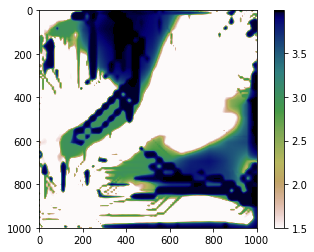

In [20]:
plt.imshow(future_extent[0:1000, 0:1000], cmap="gist_earth_r", vmin = 1.5)
plt.colorbar()

In [48]:
%%capture
high_level_mask = 1 - Nxtp(MRVBFL_1, 3, 2)
future_extent = generic_filter(high_level_mask, gaussian_filter, footprint= rectangleWindow(11,11), 
                            mode='nearest', extra_arguments = (kernel_1d,))
prediction_mask = resample_resolution_higher(future_extent, 1)
MRVBF[MRVBF < 3.5] = 0
MRVBF[MRVBF >= 3.5] = 1


In [14]:
y = 1 - Nxtp(prediction_mask, 0.5, 4)

[[ 0.0048609   0.00788809  0.01091528 ...,         nan         nan  0.        ]
 [ 0.00586797  0.00940089  0.01293382 ...,         nan         nan  0.        ]
 [ 0.00687503  0.0109137   0.01495236 ...,         nan         nan  0.        ]
 ..., 
 [        nan         nan         nan ...,         nan         nan  0.        ]
 [        nan         nan         nan ...,         nan         nan  0.        ]
 [        nan         nan         nan ...,         nan         nan  0.        ]]
0.5
4


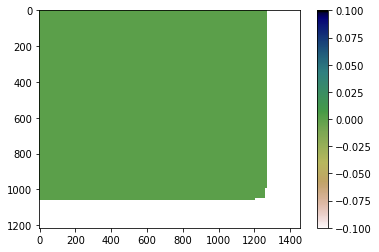

In [49]:
plt.imshow(MRVBF, cmap="gist_earth_r")
plt.colorbar()

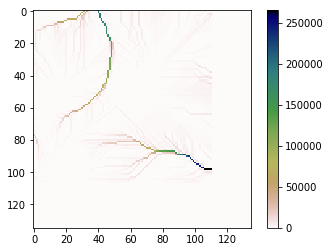

In [70]:
c = array_DEM['CA'+ '4' + '3'][0]
plt.imshow(c, cmap="gist_earth_r")
plt.colorbar()

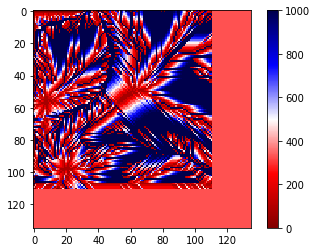

In [71]:
d = array_DEM['CA43'][0]
plt.imshow(d, cmap = 'seismic_r', vmax = 1000)
plt.colorbar()


In [89]:
%%capture
start = timeit.default_timer()

flatness_thresholds = {1:['Thresholds', 100, 60, 28, 16, 8, 4, 2, 1], 
                       5:['Thresholds', 32, 20, 10, 5, 2, 1, 0] , 
                       25:['Thresholds', 16, 8, 4, 2, 1, 0]}

steepness_thresholds = {1:['Thresholds', 30, 15, 8, 4, 2, 1, 0], 
                       5:['Thresholds', 94, 97, 98.5, 99, 100] , 
                       25:['Thresholds', 97.5, 99, 100]}

curvature_thresholds = {1:['Thresholds', 0.1, 0.1, 0.01, 0.01], 
                        5:['Thresholds', 94, 97, 98.5, 99, 100] , 
                        25:['Thresholds', 97.5, 99, 100]}

start = timeit.default_timer()
array_LL = {}
array_LL.setdefault('DEM22', []).append(DEM);
range_min = 2
range_max = level_of_generalisation
#Set starting pl value to zero.
pl_value = 1
#Set initial weight coefficient to zero.
weight_coef = 0 
radius = 6
central_value = find_median_value(circleWindow(radius))
num_values = number_of_values(circleWindow(radius))
step_L = range_max
for i in range(range_min,range_max):
    step_L -= 1
    L = str(step_L)
    print(step_L)
    Lm1 = str(int(step_L) - 1)
    Lp1 = str(int(step_L) + 1)
    if step_L > range_min:
        
        resolution_step_L = 3**(int(L) - 2) 
        DEML_L = np.copy(array_DEM['DEM'+ L + L][0])
        DEML_Lm1 = np.copy(array_DEM['DEM'+ L + Lm1][0])
        CAL_Lm1 = np.copy(array_DEM['CA'+ L + Lm1][0])
        PCTLL_L = generic_filter(DEML_L, PCTL, footprint= circleWindow(radius), mode='constant')
        zf = int(L) - 1;
        PCTLL_1 = resample_resolution_higher(PCTLL_L, zf)
        ################################################################################################
        slope_resolution = resolution_step_L = 3**(int(Lm1) - 2);  # -2 Because slope is done of L_Lm1.
        slope = generic_filter(DEML_Lm1, slopeWindowDegrees, 
                      footprint= rectangleWindow(3,3), 
                      mode='constant', extra_arguments = (slope_resolution,slope_resolution,));
        topographic_wetness_index = TWI(slope, CAL_Lm1, slope_resolution);
        TWIL_Lm1 = 1 - Nxtp(topographic_wetness_index, 6.8, 4);
        zf = int(L) - 2;
        TWIL_1 = resample_resolution_higher(TWIL_Lm1, zf);
        compound_topographic_index = CTI(slope, CAL_Lm1, slope_resolution);
        CTIL_Lm1 = 1 - Nxtp(compound_topographic_index, 18, 4);
        CTIL_1 = resample_resolution_higher(CTIL_Lm1, zf);
        TIL_1 = 1 - Nxtp(TWIL_1 * CTIL_1, 0.25, 4);
        #array_LL.setdefault('TIL'+ L + '1', []).append(TWIL_1);
        #array_LL.setdefault('CTIL'+ L + '1', []).append(CTIL_1);
        #array_LL.setdefault('TWIL'+ L + '1', []).append(TIL_1);
    
        PCTL_t = int(L)/10.0
        WPCTL2 = Nxtp(PCTLL_1, PCTL_t, 6.68);#0.4
        array_LL.setdefault('WPCTL'+ L + L, []).append(WPCTL2);
        IPCTLL_1 = 1 - PCTLL_1
        PFLL_1 = (IPCTLL_1 + TIL_1)/2
        FLL_1 = 1 - Nxtp(PFLL_1, 0.4, 4)
        array_LL.setdefault('FL'+ L + '1', []).append(FLL_1);
        ################################################################################################
    ILF_pair_generalisation = find_matching_level(int(L))[0]
    ILF_pair_resolution = find_matching_level(int(L))[1]
    DEM_ILF = np.copy(array_DEM['DEM'+ str(ILF_pair_generalisation) + str(ILF_pair_resolution)][0])
    slope_resolution = ILF_pair_resolution;
    SL = generic_filter(DEM_ILF, slopeWindow, 
                      footprint= rectangleWindow(3,3), 
                      mode='constant', extra_arguments = (slope_resolution,slope_resolution,));
    resample_factor = ILF_pair_resolution - 1
    SL_1 = resample_resolution_higher(SL, resample_factor)
    radius = 6
    central_value = find_median_value(circleWindow(radius));
    num_values = number_of_values(circleWindow(radius));
    # NOTE: CAN POTENTIALLY RESAMPLE THIS ONE LEVEL HIGHER BEFORE TAKING PCTL.
    PCTL_ILF = generic_filter(DEM_ILF, PCTL, footprint= circleWindow(radius), mode='nearest');
    PCTL_ILF_1 = resample_resolution_higher(PCTL_ILF, resample_factor);
    flatness_index = int(L) - 1
    steepness_index = int(L) - 1
    F_ILF = Nxtp(SL_1, flatness_thresholds[initial_resolution][flatness_index], 4);
    WS_ILF = 1 - Nxtp(SL_1, steepness_thresholds[initial_resolution][steepness_index], 4);
    PC_ILF = generic_filter(DEM_ILF, profileCurvature, 
                    footprint= rectangleWindow(3,3), 
                    mode='constant', extra_arguments = (ILF_pair_resolution,));
    PC_ILF_1 = resample_resolution_higher(PC_ILF, resample_factor)
    CCU_ILF = np.copy(PC_ILF_1);
    CCU_ILF[CCU_ILF > 0] = 0
    CCU_ILF_NN = np.nan_to_num(CCU_ILF);
    curvature_index = int(L) - 1
    PCCU_ILF = 1 - Nxtp(CCU_ILF_NN * -1.0, curvature_thresholds[initial_resolution][curvature_index], 3);
    PFF_ILF = PCCU_ILF * Nxtp(PCTL_ILF_1, 0.4, 3);
    FF_ILF = 1 - Nxtp(PFF_ILF, 0.3, 4);
    CVU_ILF = np.copy(PC_ILF_1);
    CVU_ILF[CVU_ILF < 0] = 0
    CVU_ILF_NN = np.nan_to_num(CVU_ILF)
    PCVU_ILF = 1 - Nxtp(CVU_ILF_NN, curvature_thresholds[initial_resolution][curvature_index], 3)
    PFE_ILF = PCVU_ILF * (1 - Nxtp(PCTL_ILF_1, 0.4, 3))#0.5
    FE_ILF = 1 - Nxtp(PFE_ILF, 0.25, 4)
    PVF_ILF = F_ILF* Nxtp(PCTL_ILF_1, 0.3,3) #0.4
    VF_ILF = 1 - Nxtp(PVF_ILF, 0.3, 4)
    PWS_ILF = WS_ILF * Nxtp(PCTL_ILF_1, 0.4, 3)#0.5
    FW_ILF = 1 - Nxtp(PWS_ILF, 0.3, 4)
    FV_ILF = np.maximum(FW_ILF, VF_ILF)
    FVE_ILF = np.maximum(FV_ILF, FE_ILF)
    FVEF_ILF = np.maximum(FVE_ILF, FF_ILF) 
    FVEFG_ILF = generic_filter(FVEF_ILF, gaussian_filter, footprint= rectangleWindow(11,11), 
                            mode='nearest', extra_arguments = (kernel_1d,))
    ###################################################################################################
    # Here the 'if' statement is just saying that if the algorithm has reached the lowest level
    # then we don't want to combine ILF with higher level indicators (TWI/CTI) because we just we
    # to extract the features and not worry about the prediction part.
    
    if L == str(range_min):
        MAPILF_L = FVEFG_ILF
        array_LL.setdefault('MAPILF'+ L + '1', []).append(MAPILF_L);
    else:
        MAPILF_L = FVEFG_ILF * FLL_1
        array_LL.setdefault('MAPILF'+ L + '1', []).append(MAPILF_L);

In [90]:
%%capture
MAPILF51 = array_LL['MAPILF51'][0]
MAPILF41 = array_LL['MAPILF41'][0]
MAPILF31 = array_LL['MAPILF31'][0]
MAPILF21 = array_LL['MAPILF21'][0]

WF1 = 1 - Nxtp(MAPILF41, 0.3, 6.68); # 0.25 here because MAOILF = FVEFG1 * FLL_1
MAPILFint = WF1 * (1 + MAPILF41) + (1 - WF1)*MAPILF51

pl = (math.log((2 - 0.5)/0.1)) / math.log(1.5)
WL_2 = 1 - Nxtp(MAPILF31, 0.3, pl) # Same as above
MAPILF_unsmoothed1 = (WL_2 * (2 + MAPILF31)) + ((1 - WL_2) * MAPILFint)

pl = (math.log((3 - 0.5)/0.1)) / math.log(1.5)
WL_3 = 1 - Nxtp(MAPILF21, 0.3, pl) # Same as above
MAPILF_unsmoothed2 = (WL_3 * (3 + MAPILF21)) + ((1 - WL_3) * MAPILF_unsmoothed1)

In [91]:
MAPILF = generic_filter(MAPILF_unsmoothed2, gaussian_filter, footprint= rectangleWindow(11,11), 
                            mode='nearest', extra_arguments = (kernel_1d,))

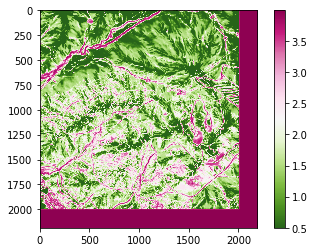

In [92]:
plt.imshow(MAPILF, cmap = 'PiYG_r', vmin = 0.5)
plt.colorbar()

In [100]:
MAPILF_masked = MAPILF * MRVBF

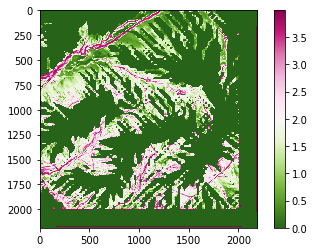

In [101]:
plt.imshow(MAPILF_masked, cmap = 'PiYG_r')
plt.colorbar()

In [26]:
p22 = array_LL['WPCTL22'][0]
p33 = array_LL['WPCTL33'][0]
p44 = array_LL['WPCTL44'][0]
p55 = array_LL['WPCTL55'][0]

pcc = p22 + p33 + p44 
lowness = pcc * mask
low_mask = 1 - Nxtp(lowness, 0.5, 4)

[[ 0.00268939  0.00269681  0.00270427 ...,  0.          0.          0.        ]
 [ 0.00274973  0.00275841  0.00276712 ...,  0.          0.          0.        ]
 [ 0.00281179  0.00282179  0.00283183 ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
0.5
4


In [27]:
%%capture
p22 = array_LL['FL21'][0]
p33 = array_LL['FL31'][0]
p44 = array_LL['FL41'][0]
p55 = array_LL['FL51'][0]

WF1 = 1 - Nxtp(p22, 0.3, 6.68); # 0.25 here because MAOILF = FVEFG1 * FLL_1
MAPILFint = WF1 * (1 + p55) + (1 - WF1)*p33

pl = (math.log((2 - 0.5)/0.1)) / math.log(1.5)
WL_2 = 1 - Nxtp(p44, 0.3, pl) # Same as above
MAPILF_unsmoothed1 = (WL_2 * (2 + p44)) + ((1 - WL_2) * MAPILFint)

pl = (math.log((3 - 0.5)/0.1)) / math.log(1.5)
WL_3 = 1 - Nxtp(p55, 0.3, pl) # Same as above
MAPILF_unsmoothed2 = (WL_3 * (3 + p55)) + ((1 - WL_3) * MAPILF_unsmoothed1)
lowness = pcc * mask
low_mask = 1 - Nxtp(lowness, 0.5, 4)

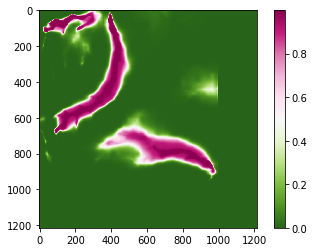

In [28]:
plt.imshow(low_mask, cmap="PiYG_r")
plt.colorbar()

In [29]:
MAPILF_masked = MAPILF * low_mask

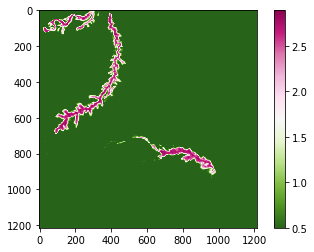

In [30]:
plt.imshow(MAPILF_masked, cmap = 'PiYG_r', vmin = 0.5)
plt.colorbar()

In [ ]:
number_of_ticks = 5

DEM33_image = array_DEM['DEM22'][0]
DEM33max = int(np.amax(DEM33_image))
DEM33min = int(np.amin(DEM33_image))
DEM33dif = DEM33max - DEM33min
DEM33noticks = int(DEM33dif / number_of_ticks)
ticklistDEM33 = np.arange(DEM33min, DEM33max + 1, DEM33noticks)

DEM43_image = array_DEM['DEM32'][0]
DEM43max = int(np.amax(DEM43_image))
DEM43min = int(np.amin(DEM43_image))
DEM43dif = DEM33max - DEM43min
DEM43noticks = int(DEM43dif / number_of_ticks)
ticklistDEM43 = np.arange(DEM43min, DEM43max + 1, DEM43noticks)

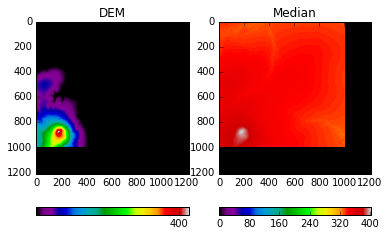

In [4]:
fig = plt.figure()
a = fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(DEM33_image, cmap="nipy_spectral", vmin = 350)
a.set_title('DEM')
plt.colorbar(ticks = ticklistDEM33, orientation = 'horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(DEM43_image, cmap="nipy_spectral")
a.set_title('Median')
plt.colorbar (ticks = ticklistDEM43, orientation = 'horizontal')


In [19]:
def np_array_to_Geotiff(newfile, original_tiff, np_array, dtype):
    
    cols = np_array.shape[1]
    rows = np_array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = ds.GetGeoTransform() 
    driver = gdal.GetDriverByName('GTiff')
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Float64": 
        GDT_dtype = gdal.GDT_Float64
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")
    
    if np_array.ndim == 2:
        band_num = 1
    else:
        band_num = np_array.shape[2]

    outRaster = driver.Create(newfile, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    
    # Loop over all bands.
    for b in range(band_num):
        outband = outRaster.GetRasterBand(b + 1)
    
        # Read in the band's data into the third dimension of our array
        if band_num == 1:
            outband.WriteArray(np_array)
        else:
            outband.WriteArray(np_array[:,:,b])

    # setteing srs from input tif file.
    prj=original_tiff.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    outRaster = None
    
    return outRaster

In [102]:
np_array_to_Geotiff('coppins_test.tif', ds, MAPILF_masked, MAPILF.dtype)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [306]:
np_array_to_Geotiff('coppins_low.tif', ds, lowness, pcc.dtype)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [ ]:
#MRVBF2 = WF2 * (1 + VF2) + (1 - WF2)*VF1
#MRFWS2 = WFW2 * (1 + FW2) + (1 - WFW2)*FW1
#MRFFC2 = WFF2 * (1 + FF2) + (1 - WFF2)*FF1
#MRFEC2 = WFE2 * (1 + FE2) + (1 - WFE2)*FE1

In [106]:
np_array_to_Geotiff('painter_w.tif', ds, MRFWS2, b.dtype)

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
  


In [33]:
np_array_to_Geotiff('wean_DEM33.tif', ds, DEM33, DEM66.dtype)

In [144]:
np_array_to_Geotiff('wean_PCTL.tif', ds, PCTLF_F, PCTLF_F.dtype)

In [43]:
np_array_to_Geotiff('wean_pc.tif', ds, pc, input_DEM.dtype)